In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Define the data directories
normal_dir = 'Processed_Normal'
hemorrhage_dir = 'Processed_Hemorrhage'
# Get the list of all the images
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
hemorrhage_images = [os.path.join(hemorrhage_dir, img) for img in os.listdir(hemorrhage_dir)]
# Create labels
normal_labels = [0]*len(normal_images)  # let's assume 0 for normal
hemorrhage_labels = [1]*len(hemorrhage_images)  # and 1 for hemorrhage

# Concatenate data and labels
images = normal_images + hemorrhage_images
labels = normal_labels + hemorrhage_labels


In [3]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

PyTorch uses a Dataset object, which is an abstract class representing a dataset, and a DataLoader, which wraps an iterable around the Dataset. Here's how you can create a custom Dataset for your images:

In [4]:
from torch.utils.data import Dataset
from PIL import Image

class BrainCTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

from torch.utils.data import DataLoader

# Define transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create the datasets
train_dataset = BrainCTDataset(train_images, train_labels, transform=data_transforms['train'])
val_dataset = BrainCTDataset(val_images, val_labels, transform=data_transforms['val'])

# Create the dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32,shuffle=True, ),  # num_workers=4 for higher worker we can use os.cpu_count()
    'valid': DataLoader(val_dataset, batch_size=32,shuffle=False,),
}


Training Images:


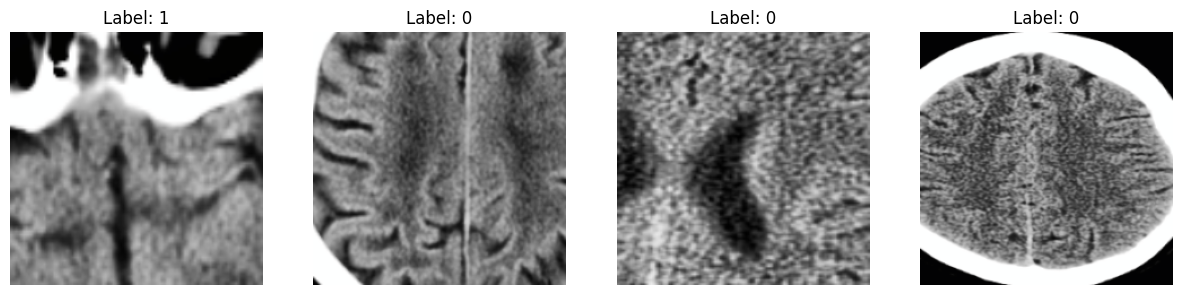

Validation Images:


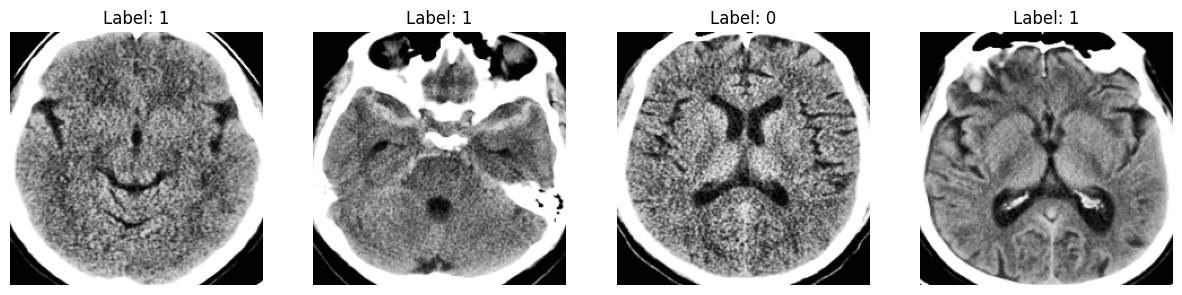

In [5]:
def visualize_random_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,5))

    for index,image in enumerate(images[:num_images]):
        plt.subplot(1, num_images,index+1)
        # Unnormalize and display the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[index].item()}")
        plt.axis("off")
    plt.show()

# Visualize random images from training dataset
print("Training Images:")
visualize_random_images(dataloaders['train'])

# Visualize random images from validation dataset
print("Validation Images:")
visualize_random_images(dataloaders['valid'])


## feature extraction Resnet152


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = models.resnet152(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.to(device)

cuda:0


C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
features_children = list(model.children())
truncated_features_children = features_children[:-3]
truncated_features = nn.Sequential(*truncated_features_children)
truncated_features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [18]:
sample_input = torch.randn(1, 3, 224, 224).to(device)  # Assuming an input size of 224x224 with 3 channels
output = truncated_features(sample_input)
print(output.shape)
in_features = output.numel() // output.shape[0]  # This gives you the flattened size per sample in the batch
in_features

torch.Size([1, 1024, 14, 14])


200704

In [19]:
from collections import OrderedDict

# Replace the classifier (it will also be trainable by default)

classifier = nn.Linear(in_features, 2)  # Assuming you have 2 classes

# Combine the truncated features and the classifier into a new model
model = nn.Sequential(OrderedDict([
    ("features", truncated_features),
    ("flatten", nn.Flatten()),
    ("classifier", classifier)
]))

model.to(device)


Sequential(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [20]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                        Param #
Sequential                                    --
├─Sequential: 1-1                             --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   (75,008)
│    │    └─Bottleneck: 3-2                   (70,400)
│    │    └─Bottleneck: 3-3                   (70,400)
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   (379,392)
│    │    └─Bottleneck: 3-5                   (280,064)
│    │    └─Bottleneck: 3-6                   (280,064)
│    │    └─Bottleneck: 3-7                   (280,064)
│    │    └─Bottleneck: 3-8                   (280,064)
│    │    └─Bottleneck: 3-9                   (280,064)
│    │    └─Bottleneck: 3-10                 

In [21]:
import time
import copy
from tqdm.auto import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Here we will save the metrics
    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    dataset_sizes = {
        'train': len(train_dataset),
        'valid': len(val_dataset)
    }

    for epoch in tqdm(range(1, num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Store the loss and accuracy values
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


c:\Users\moheb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
----------
train Loss: 1.3025 Acc: 0.6665


  5%|▌         | 1/20 [00:48<15:14, 48.14s/it]

valid Loss: 0.7577 Acc: 0.7380

Epoch 2/20
----------
train Loss: 1.0034 Acc: 0.6934


 10%|█         | 2/20 [01:26<12:38, 42.13s/it]

valid Loss: 0.8367 Acc: 0.7128

Epoch 3/20
----------
train Loss: 1.1658 Acc: 0.6800


 15%|█▌        | 3/20 [02:04<11:28, 40.47s/it]

valid Loss: 0.9758 Acc: 0.7330

Epoch 4/20
----------
train Loss: 1.1698 Acc: 0.6886


 20%|██        | 4/20 [02:42<10:33, 39.62s/it]

valid Loss: 1.0438 Acc: 0.7531

Epoch 5/20
----------
train Loss: 1.4962 Acc: 0.6636


 25%|██▌       | 5/20 [03:27<10:19, 41.31s/it]

valid Loss: 1.0332 Acc: 0.7649

Epoch 6/20
----------
train Loss: 1.2341 Acc: 0.6921


 30%|███       | 6/20 [04:18<10:25, 44.71s/it]

valid Loss: 0.7438 Acc: 0.7834

Epoch 7/20
----------
train Loss: 1.1040 Acc: 0.7024


 35%|███▌      | 7/20 [05:09<10:06, 46.63s/it]

valid Loss: 0.8937 Acc: 0.7733

Epoch 8/20
----------
train Loss: 1.2074 Acc: 0.7003


 40%|████      | 8/20 [05:50<08:59, 44.97s/it]

valid Loss: 0.8093 Acc: 0.7515

Epoch 9/20
----------
train Loss: 1.1050 Acc: 0.7068


 45%|████▌     | 9/20 [06:28<07:51, 42.88s/it]

valid Loss: 0.9086 Acc: 0.7322

Epoch 10/20
----------
train Loss: 1.1465 Acc: 0.7106


 50%|█████     | 10/20 [07:07<06:54, 41.49s/it]

valid Loss: 0.8457 Acc: 0.7473

Epoch 11/20
----------
train Loss: 1.3675 Acc: 0.6951


 55%|█████▌    | 11/20 [07:45<06:04, 40.50s/it]

valid Loss: 0.8833 Acc: 0.7515

Epoch 12/20
----------
train Loss: 1.1296 Acc: 0.7077


 60%|██████    | 12/20 [08:23<05:18, 39.85s/it]

valid Loss: 0.8468 Acc: 0.7624

Epoch 13/20
----------
train Loss: 1.4874 Acc: 0.6879


 65%|██████▌   | 13/20 [09:02<04:35, 39.37s/it]

valid Loss: 1.1050 Acc: 0.7666

Epoch 14/20
----------
train Loss: 1.2779 Acc: 0.7110


 70%|███████   | 14/20 [09:40<03:53, 38.95s/it]

valid Loss: 1.2297 Acc: 0.6902

Epoch 15/20
----------
train Loss: 1.2697 Acc: 0.7056


 75%|███████▌  | 15/20 [10:18<03:13, 38.70s/it]

valid Loss: 1.2745 Acc: 0.6877

Epoch 16/20
----------
train Loss: 1.1513 Acc: 0.7182


 80%|████████  | 16/20 [10:56<02:34, 38.53s/it]

valid Loss: 0.7469 Acc: 0.7943

Epoch 17/20
----------
train Loss: 1.1152 Acc: 0.7239


 85%|████████▌ | 17/20 [11:34<01:55, 38.40s/it]

valid Loss: 1.5713 Acc: 0.6499

Epoch 18/20
----------
train Loss: 1.4924 Acc: 0.6972


 90%|█████████ | 18/20 [12:12<01:16, 38.31s/it]

valid Loss: 0.8016 Acc: 0.7976

Epoch 19/20
----------
train Loss: 1.1802 Acc: 0.7247


 95%|█████████▌| 19/20 [12:56<00:40, 40.06s/it]

valid Loss: 2.1814 Acc: 0.6910

Epoch 20/20
----------
train Loss: 1.1368 Acc: 0.7304


100%|██████████| 20/20 [13:50<00:00, 41.51s/it]

valid Loss: 1.2133 Acc: 0.7531

Training complete in 13m 51s
Best valid accuracy: 0.797649


In [26]:
# Switch to evaluation mode
model.eval()

# Initialize the prediction and label lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat)

# Compute the classification report
from sklearn.metrics import classification_report
class_report=classification_report(lbllist.numpy(), predlist.numpy())
print('Classification Report')
print('-'*20)
print(class_report)


Confusion Matrix
----------------
[[627  56]
 [185 323]]
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       683
           1       0.85      0.64      0.73       508

    accuracy                           0.80      1191
   macro avg       0.81      0.78      0.78      1191
weighted avg       0.81      0.80      0.79      1191



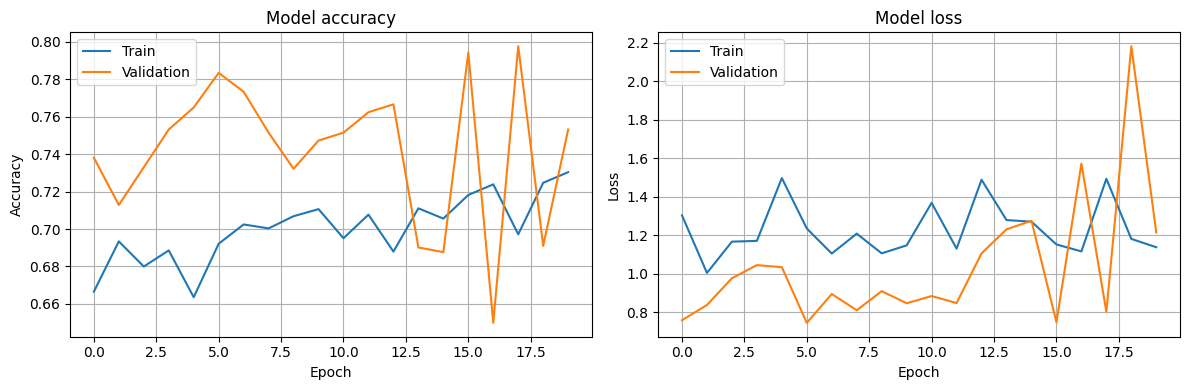

: 

In [27]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # plot training and validation accuracy values
    ax1.plot(history['train_acc'], label='Train')
    ax1.plot(history['valid_acc'], label='Validation')
    ax1.set_title("Model accuracy")
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # plot training and validation loss values
    ax2.plot(history['train_loss'], label='Train')
    ax2.plot(history['valid_loss'], label='Validation')
    ax2.set_title("Model loss")
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
model.state_dict()